# Autoencoder for getting vector embeddings

**Advisor:** Marcos M. Raimundo <br>
**Co-Advisor:** Thalita Veronese <br>
**Student:** João Victor P. B. Avanzini

## Imports

In [1]:
import tensorflow as tf
import os

import neurokit2 as nk


import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.keras import TqdmCallback

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, Conv2D, MaxPooling1D, MaxPooling2D, Flatten, Input, Conv1DTranspose, Conv2DTranspose, Reshape
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten, Input, Conv1DTranspose, Reshape, UpSampling1D
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.layers import Dense, LSTM


from matplotlib.offsetbox import OffsetImage, AnnotationBbox

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, UpSampling1D, Conv1DTranspose, RepeatVector, Reshape, TimeDistributed
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, Flatten, GlobalMaxPooling1D


sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

2023-12-21 20:23:31.585195: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-21 20:23:31.585229: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-21 20:23:31.586241: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-21 20:23:31.593583: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-21 20:23:32.473350: W tensorflow/compiler/tf2

Device mapping: no known devices.


2023-12-21 20:23:34.503277: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:274] failed call to cuInit: CUDA_ERROR_COMPAT_NOT_SUPPORTED_ON_DEVICE: forward compatibility was attempted on non supported HW
2023-12-21 20:23:34.503305: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:129] retrieving CUDA diagnostic information for host: 033b258647f7
2023-12-21 20:23:34.503312: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:136] hostname: 033b258647f7
2023-12-21 20:23:34.503420: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:159] libcuda reported version is: 515.105.1
2023-12-21 20:23:34.503441: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:163] kernel reported version is: 470.223.2
2023-12-21 20:23:34.503448: E external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:244] kernel version 470.223.2 does not match DSO version 515.105.1 -- cannot find working devices in this configuration


## 50 Subjects of single ECG autoencoder

In [2]:
subjects = pd.read_csv('../scripting/ecg_downloader/data/merged_ecg_data.csv')

In [3]:
subjects.shape

(9000000, 1)

In [4]:
subjects_reshaped = subjects.values.reshape((1500, 6000))
subjects_reshaped.shape

(1500, 6000)

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

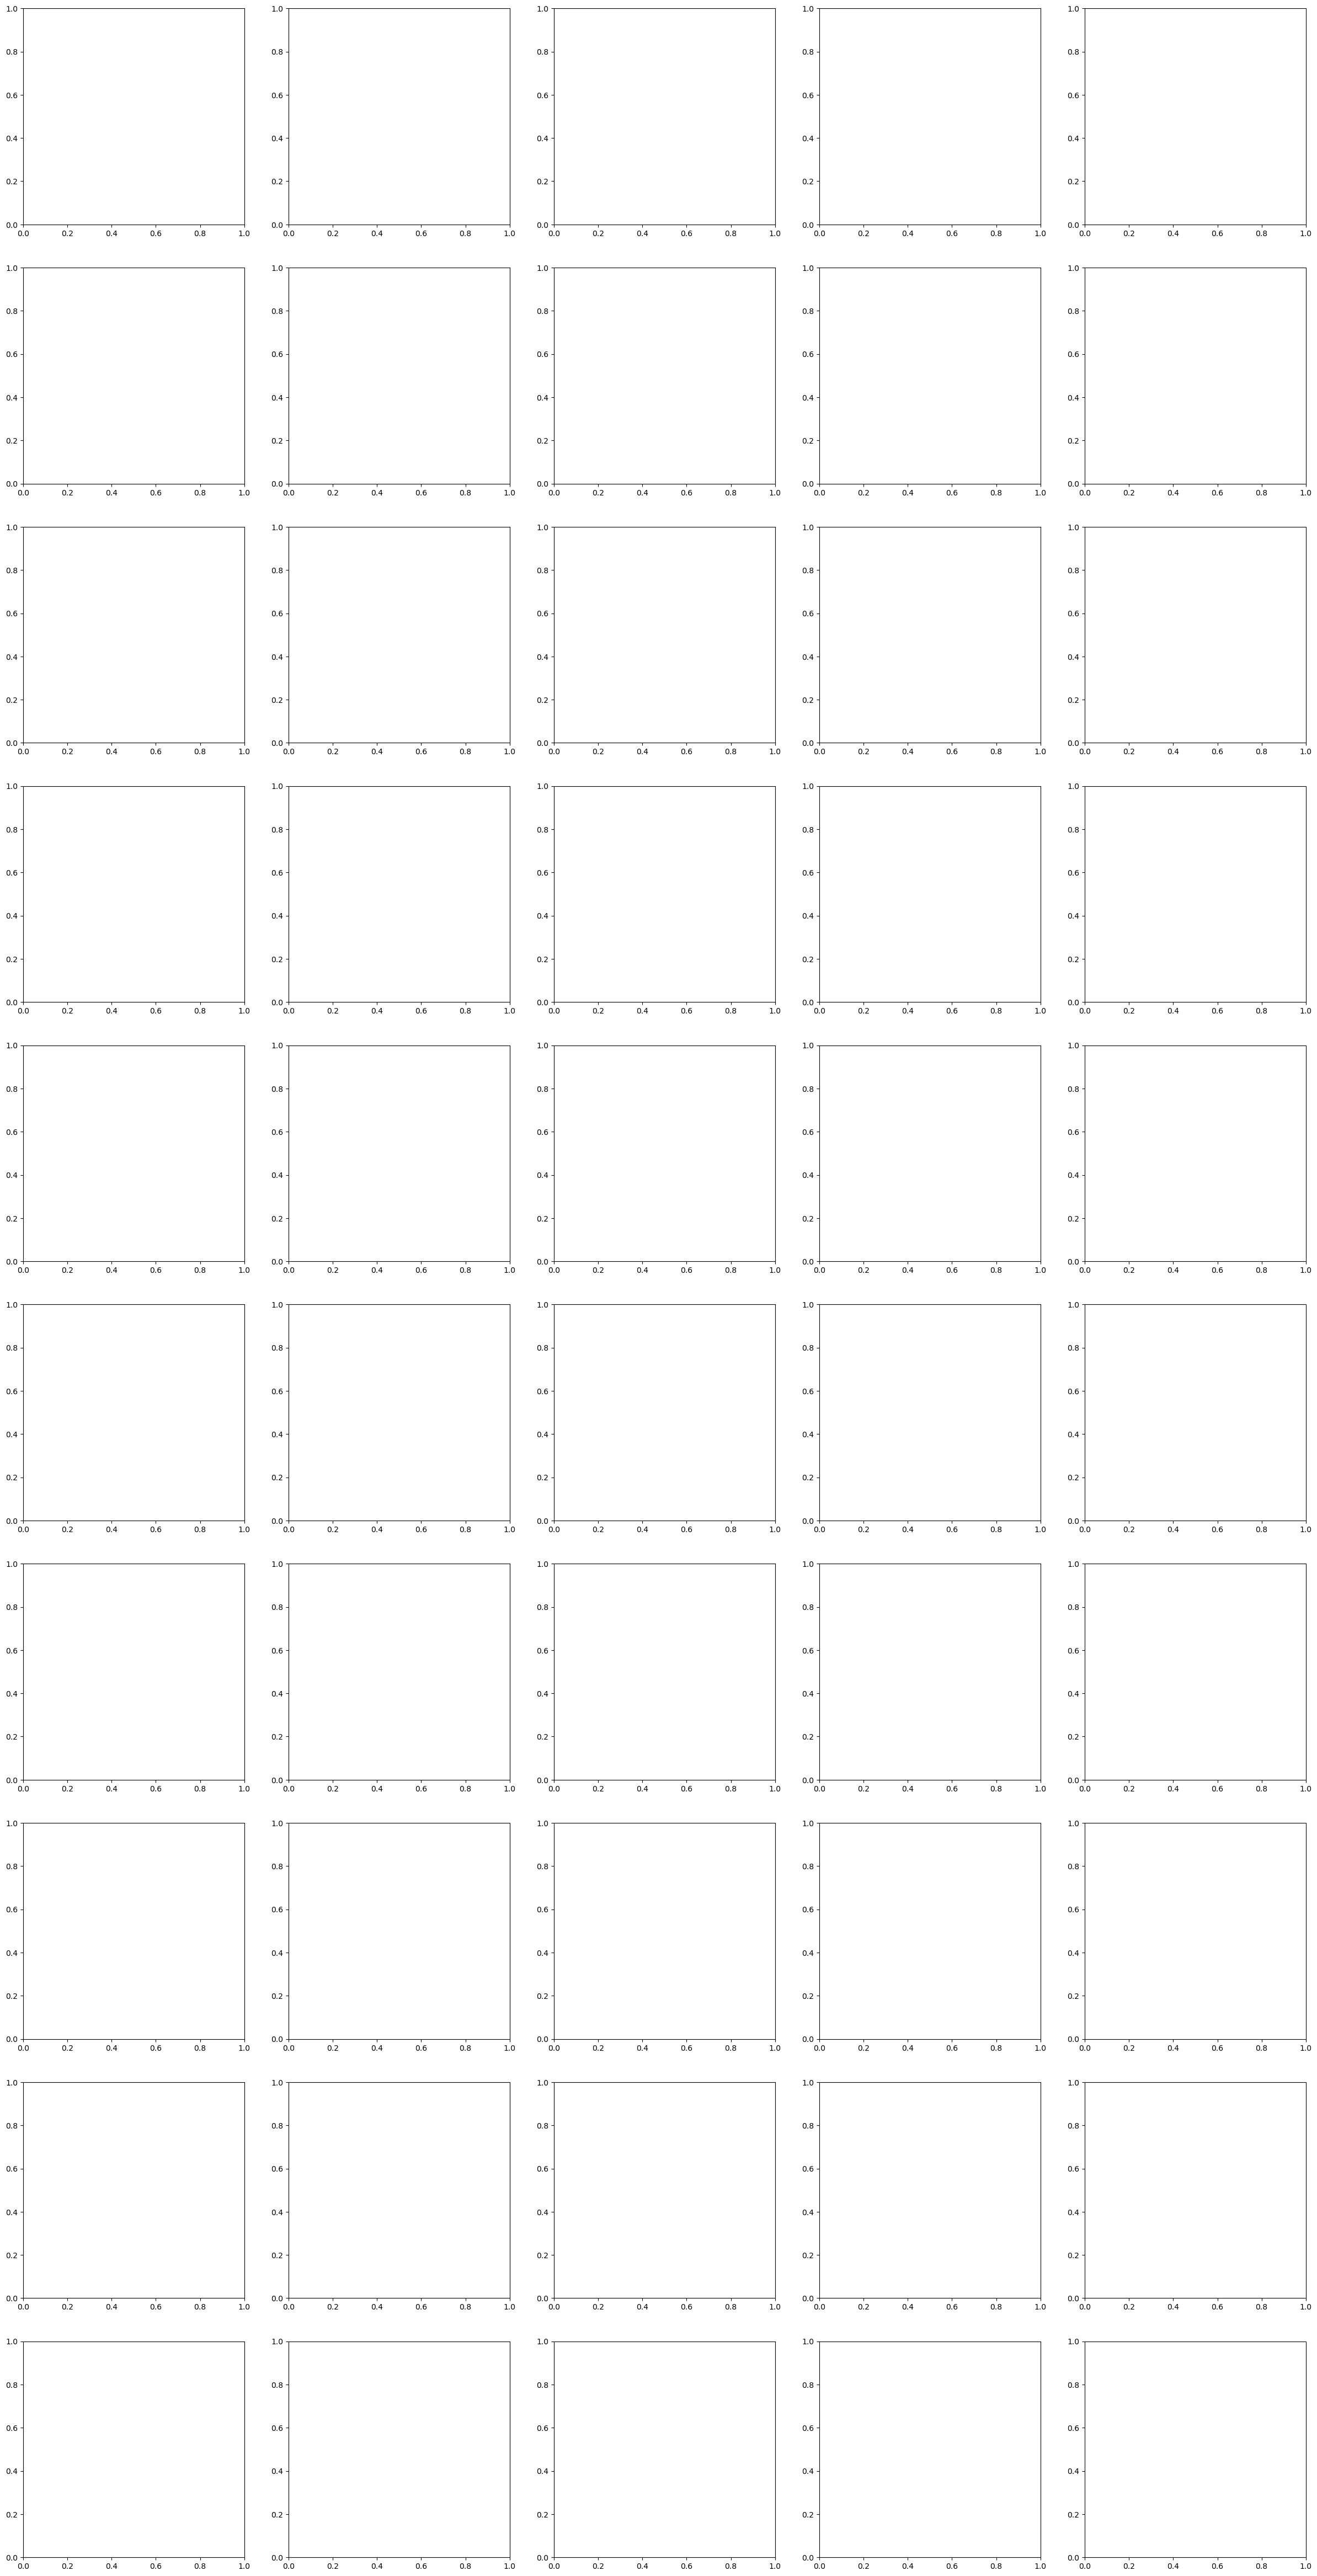

In [5]:
num_pacientes = 50
pontos_por_blob = 1000
blob_selecionado = 1
num_blobs = 1
num_linhas = 10
num_colunas = num_pacientes // num_linhas

fig, axs = plt.subplots(num_linhas, num_colunas, figsize=(30, 60))

for paciente in range(num_pacientes):
    linha = paciente // num_colunas
    coluna = paciente % num_colunas
    
    dados_paciente_blob = subjects_reshaped[paciente * num_blobs + (blob_selecionado - 1), :pontos_por_blob, 0].flatten()
    
    axs[linha, coluna].plot(dados_paciente_blob, label=f'Blob {blob_selecionado}')

    axs[linha, coluna].set_title(f'Paciente {paciente + 1}')
    axs[linha, coluna].set_xlabel('Pontos')
    axs[linha, coluna].set_ylabel('Valor do Sinal')
    axs[linha, coluna].legend()

plt.tight_layout()
plt.show()

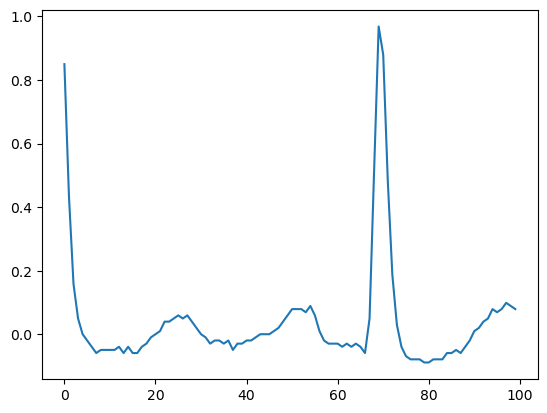

In [6]:
plt.plot(subjects_reshaped[1][:100])

In [7]:
strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [8]:
cut = subjects_reshaped[:,:100]
cut.shape

(1500, 100)

In [9]:
with strategy.scope():
    encoder = tf.keras.models.Sequential([
        #Input(shape=(100,)),
        Dense(32, activation="relu"),
        Dense(16, activation="relu"),
        Dense(8, activation="relu")
    ], name='encoder')

    decoder = tf.keras.models.Sequential([
        Dense(16, activation="relu"),
        Dense(32, activation="relu"),
        Dense(100, activation="sigmoid")
    ], name='decoder')
    
    #custom_optimizer = Adam(learning_rate=1e-5)
    autoencoder = Sequential([encoder, decoder])
    autoencoder.compile(optimizer="adam", loss="mae")

history = autoencoder.fit(cut, cut, batch_size=512, epochs=100, verbose=1)

Epoch 1/100


2023-12-21 20:23:47.278445: W tensorflow/core/framework/dataset.cc:959] Input of GeneratorDatasetOp::Dataset will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.


3/3 [==============================] - 1s 6ms/step - loss: 0.4980
Epoch 2/100
3/3 [==============================] - 0s 5ms/step - loss: 0.4967
Epoch 3/100
3/3 [==============================] - 0s 5ms/step - loss: 0.4955
Epoch 4/100
3/3 [==============================] - 0s 5ms/step - loss: 0.4941
Epoch 5/100
3/3 [==============================] - 0s 4ms/step - loss: 0.4924
Epoch 6/100
3/3 [==============================] - 0s 5ms/step - loss: 0.4903
Epoch 7/100
3/3 [==============================] - 0s 5ms/step - loss: 0.4876
Epoch 8/100
3/3 [==============================] - 0s 6ms/step - loss: 0.4841
Epoch 9/100
3/3 [==============================] - 0s 6ms/step - loss: 0.4796
Epoch 10/100
3/3 [==============================] - 0s 6ms/step - loss: 0.4738
Epoch 11/100
3/3 [==============================] - 0s 6ms/step - loss: 0.4663
Epoch 12/100
3/3 [==============================] - 0s 6ms/step - loss: 0.4566
Epoch 13/100
3/3 [==============================] - 0s 7ms/step - loss: 0

In [10]:
encoder.summary()

Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                3232      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
Total params: 3896 (15.22 KB)
Trainable params: 3896 (15.22 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 16)                144       
                                                                 
 dense_4 (Dense)             (None, 32)                544       
                                                                 
 dense_5 (Dense)             (None, 100)               3300      
                                                                 
Total params: 3988 (15.58 KB)
Trainable params: 3988 (15.58 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


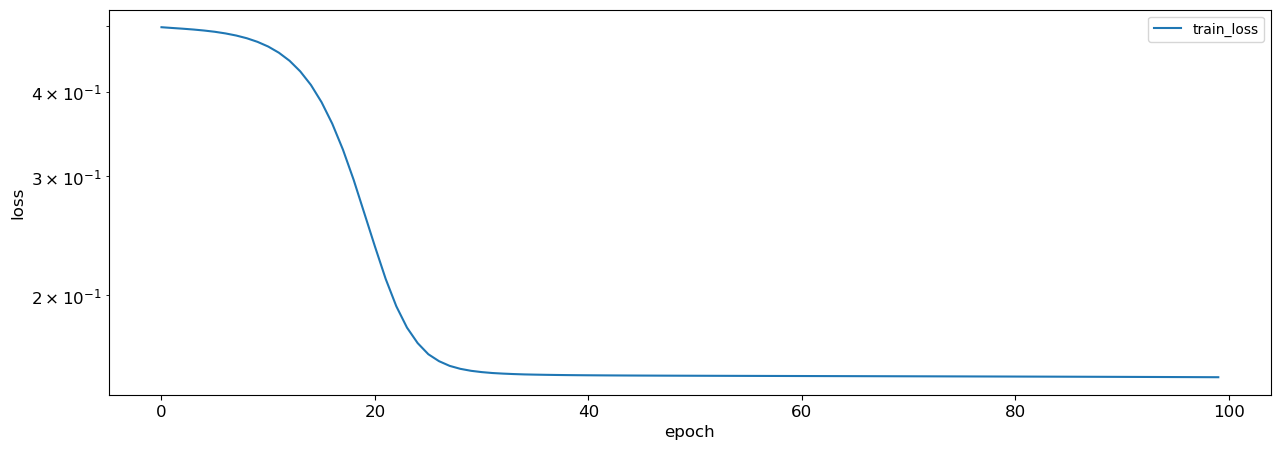

In [12]:
plot_df = pd.DataFrame.from_dict({'train_loss':history.history['loss']})
plot_df.plot(logy=True, figsize=(15,5), fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.ylabel('loss', fontsize=12)
plt.show()

## Inference

In [13]:
#subject_60 = pd.read_csv('../scripting/ecg_downloader/data/output_blobs_case_60/all_subject_60_blobs.csv')

In [14]:
#subject_60.shape

In [15]:
#subject_60_reshaped = subject_60.values.reshape((5, 30000, 1))
#subject_60_reshaped.shape

In [16]:
latent_representations = encoder.predict(cut)
latent_representations

47/47 [==============================] - 0s 2ms/step


array([[ 4.153817  ,  0.        ,  0.        , ..., 10.398317  ,
         0.5045544 ,  7.6285806 ],
       [ 1.0663341 ,  0.37924096,  0.        , ...,  2.273268  ,
         0.94397295,  2.0770092 ],
       [ 0.7110769 ,  0.5539812 ,  0.        , ...,  1.9692082 ,
         1.0310179 ,  1.790616  ],
       ...,
       [ 1.4661    ,  0.32635647,  0.        , ...,  3.5371277 ,
         0.86025476,  2.8369188 ],
       [ 1.5721595 ,  0.        ,  0.        , ...,  3.589579  ,
         0.24127056,  2.7452924 ],
       [ 1.0246438 ,  0.        ,  0.        , ...,  2.3564126 ,
         0.38617224,  1.9439968 ]], dtype=float32)

In [17]:
generated_ecgs = decoder.predict(latent_representations)
generated_ecgs.shape

47/47 [==============================] - 0s 2ms/step


(1500, 100)

Text(0, 0.5, 'Signal Value')

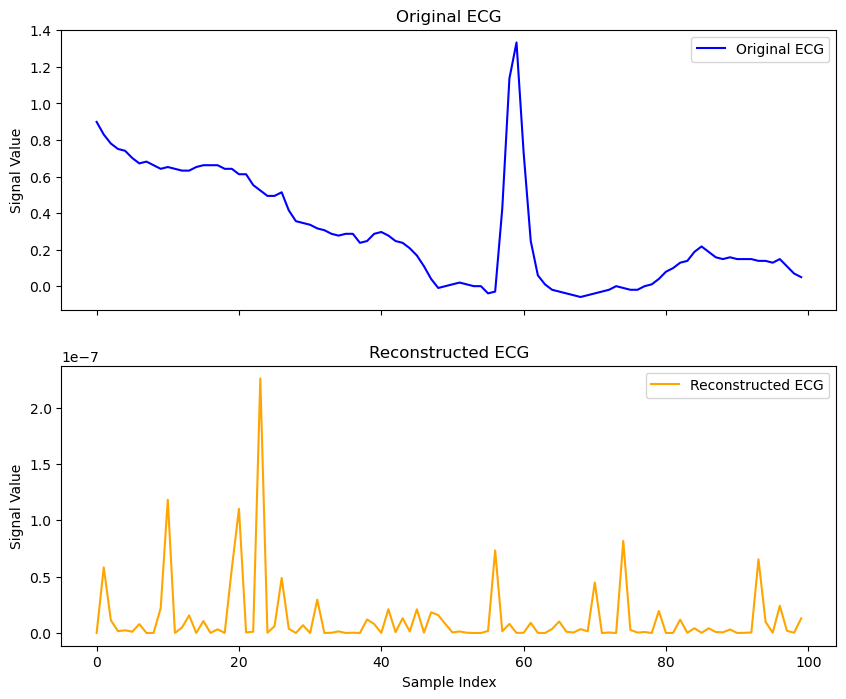

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

axs[0].plot(cut[0], label='Original ECG', color='blue')
axs[0].legend()
axs[0].set_title('Original ECG')
axs[0].set_ylabel('Signal Value')

axs[1].plot(generated_ecgs[0], label='Reconstructed ECG', color='orange')
axs[1].legend()
axs[1].set_title('Reconstructed ECG')
axs[1].set_xlabel('Sample Index')
axs[1].set_ylabel('Signal Value')

In [19]:
mse = np.mean(np.square(cut[0] - generated_ecgs[0]))
print(f'Mean Squared Error (MSE): {mse}')

Mean Squared Error (MSE): 0.1767462182136793
